In this code, to test the method as from the github code using Hy and Ez, need to refer that pdf again

In [9]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
mp.verbosity(0)

def simulate_mmi(L, W, D, w=1, resolution=20, fcen=1, df=0.1, buff=1, dpml=0.5, sx=15, sy=12, n=3):
    # Calculate the offset d for smaller blocks
    d = D * (W / 2 - w)

    # Define the simulation cell
    cell = mp.Vector3(sx, sy)

    # Define the geometry of the MMI structure
    geometry = [
        mp.Block(center=mp.Vector3(), size=mp.Vector3(L, W), material=mp.Medium(index=n)),
        mp.Block(center=mp.Vector3(-sx / 4), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
        mp.Block(center=mp.Vector3(sx / 4, d + w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
        mp.Block(center=mp.Vector3(sx / 4, -d - w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n))
    ]

    # Define the boundary conditions
    pml_layers = [mp.PML(dpml)]

    # Define the source of excitation
    sources = [mp.EigenModeSource(
        src=mp.GaussianSource(fcen, fwidth=df),
        center=mp.Vector3(x=-sx / 2 + buff + dpml),
        size=mp.Vector3(0, 3 * w, 0),
        component=mp.Ez,
        eig_match_freq=True
    )]

    # Initialize the simulation
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        sources=sources,
        resolution=resolution,
        boundary_layers=pml_layers,
        default_material=mp.Medium(index=1),
        symmetries=[mp.Mirror(mp.Y, phase=1)]
    )

    # Add a DFT monitor for the forward fields
    plane_monitor = sim.add_dft_fields(
        [mp.Ez],  # Monitor the Ez component
        fcen, df, 1,  # Center frequency, frequency width, number of frequencies
        where=mp.Volume(center=mp.Vector3(), size=cell)
    )

    # Run the simulation until the fields decay
    pt = mp.Vector3(sx / 2 - buff - dpml, d + w / 2)
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-4))

    # Extract the forward fields from the monitor
    forward_fields = sim.get_dft_array(plane_monitor, mp.Ez, 0)

    return forward_fields, sim

# Example usage
L = 7
W = 7
D = 0.5

In [10]:
forward_fields, sim=simulate_mmi(L, W, D)

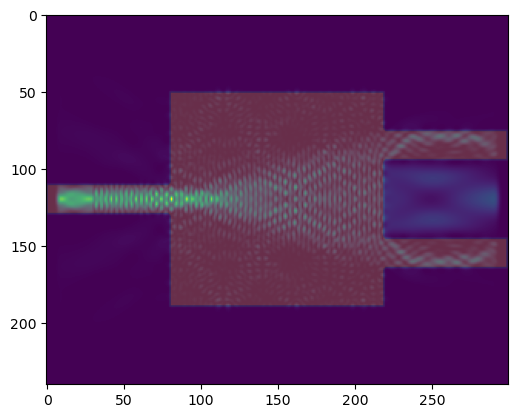

In [11]:
refind = np.transpose(sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Dielectric))
Ezdat = np.transpose(sim.get_array(center=mp.Vector3(), size=sim.cell_size, component=mp.Ez))
I=np.square(np.abs(Ezdat))

plt.imshow(np.square(np.abs(forward_fields.transpose())))
plt.imshow(refind, alpha=0.2)

In [12]:
def extract_O1_fields(simulation, forward_fields, L, W, D, w=1, buff=1, dpml=0.5, sx=15, sy=12):
    d = D * (W / 2 - w)
    
    # Define the center of the O1 monitor
    O1_center = mp.Vector3(sx / 2 - buff - dpml, d + w / 2)

    # Convert the center position to grid indices
    resolution = simulation.resolution
    O1_x_index = int((O1_center.x + sx / 2) * resolution)
    O1_y_index_start = int((O1_center.y - w / 2 + sy / 2) * resolution)
    O1_y_index_end = int((O1_center.y + w / 2 + sy / 2) * resolution)

    # Extract the field values at O1
    O1_fields = forward_fields[O1_x_index, O1_y_index_start:O1_y_index_end]

    return O1_fields

# Example usage
L = 7
W = 7
D = 0.5

def run_adjoint_simulation_with_symmetry(L, W, D, O1_fields, w=1, resolution=20, fcen=1, df=0.1, buff=1, dpml=0.5, sx=15, sy=12, n=3):
    d = D * (W / 2 - w)

    # Define the simulation cell
    cell = mp.Vector3(sx, sy)

    # Define the geometry
    geometry = [
        mp.Block(center=mp.Vector3(), size=mp.Vector3(L, W), material=mp.Medium(index=n)),
        mp.Block(center=mp.Vector3(-sx / 4), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
        mp.Block(center=mp.Vector3(sx / 4, d + w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
        mp.Block(center=mp.Vector3(sx / 4, -d - w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n))
    ]

    # Define the boundary conditions
    pml_layers = [mp.PML(dpml)]

    # Define the adjoint sources along the O1 monitor using H_y*
    sources = []
    O1_y_start = d + w / 2 - w / 2  # Starting y position of O1

    ################################################################################################################################33
    #This part of the code needs serious debugging
    for i, field_value in enumerate(O1_fields):
        y_pos = O1_y_start + (i / resolution)
        sources.append(mp.Source(
            mp.GaussianSource(frequency=fcen, fwidth=df),
            component=mp.Ez,  # Using Hy as the adjoint source component
            center=mp.Vector3(sx / 2 - buff - dpml, y_pos),
            amplitude=-np.conj(field_value)  # Using the complex conjugate 
        ))
    #######################################################################################################################################3
    # Initialize the simulation with symmetry
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        sources=sources,
        resolution=resolution,
        boundary_layers=pml_layers,
        default_material=mp.Medium(index=1)
    )

    # Add a DFT monitor to capture the adjoint fields
    volume_monitor = sim.add_dft_fields(
        [mp.Ez],  # monitor the Ez component
        fcen, df, 1,  # center frequency, frequency width, number of frequencies
        where=mp.Volume(center=mp.Vector3(), size=cell)
    )

    # Run the adjoint simulation until fields decay
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mp.Vector3(-sx/4), 1e-4))

    # Extract the adjoint fields from the monitor
    adjoint_fields = sim.get_dft_array(volume_monitor, mp.Ez, 0)

    return adjoint_fields

# Example usage
L = 7
W = 7
D = 0.5

In [13]:
def compute_d_epsilon_dL(L, W, D, w=1, resolution=20, buff=1, dpml=0.5, sx=15, sy=12, n=3):
    dpi = 2/resolution

    def get_permittivity(L):
        d = D * (W / 2 - w)
        cell = mp.Vector3(sx, sy)

        geometry = [
            mp.Block(center=mp.Vector3(), size=mp.Vector3(L, W), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(-sx / 4), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(sx / 4, d + w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(sx / 4, -d - w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n))
        ]

        sim = mp.Simulation(
            cell_size=cell,
            geometry=geometry,
            resolution=resolution,
            boundary_layers=[mp.PML(dpml)],
            default_material=mp.Medium(index=1),  symmetries=[mp.Mirror(mp.Y, phase=1)]
        )

        sim.init_sim()
        epsilon = sim.get_array(component=mp.Dielectric, center=mp.Vector3(), size=cell)
        return epsilon

    d_epsilon_dL = (get_permittivity(L + dpi / 2) - get_permittivity(L - dpi / 2)) / dpi
    return d_epsilon_dL

def compute_d_epsilon_dW(L, W, D, w=1, resolution=20, buff=1, dpml=0.5, sx=15, sy=12, n=3):
    dpi = 2/resolution

    def get_permittivity(W):
        d = D * (W / 2 - w)
        cell = mp.Vector3(sx, sy)

        geometry = [
            mp.Block(center=mp.Vector3(), size=mp.Vector3(L, W), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(-sx / 4), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(sx / 4, d + w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(sx / 4, -d - w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n))
        ]

        sim = mp.Simulation(
            cell_size=cell,
            geometry=geometry,
            resolution=resolution,
            boundary_layers=[mp.PML(dpml)],
            default_material=mp.Medium(index=1),  symmetries=[mp.Mirror(mp.Y, phase=1)]
        )

        sim.init_sim()
        epsilon = sim.get_array(component=mp.Dielectric, center=mp.Vector3(), size=cell)
        return epsilon

    d_epsilon_dW = (get_permittivity(W + dpi / 2) - get_permittivity(W - dpi / 2)) / dpi
    return d_epsilon_dW

def compute_d_epsilon_dD(L, W, D, w=1, resolution=20, buff=1, dpml=0.5, sx=15, sy=12, n=3):
    dpi = 2/resolution*2/W

    def get_permittivity(D):
        d = D * (W / 2 - w)
        cell = mp.Vector3(sx, sy)

        geometry = [
            mp.Block(center=mp.Vector3(), size=mp.Vector3(L, W), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(-sx / 4), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(sx / 4, d + w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n)),
            mp.Block(center=mp.Vector3(sx / 4, -d - w / 2), size=mp.Vector3(sx / 2, w), material=mp.Medium(index=n))
        ]

        sim = mp.Simulation(
            cell_size=cell,
            geometry=geometry,
            resolution=resolution,
            boundary_layers=[mp.PML(dpml)],
            default_material=mp.Medium(index=1),  symmetries=[mp.Mirror(mp.Y, phase=1)]
        )

        sim.init_sim()
        epsilon = sim.get_array(component=mp.Dielectric, center=mp.Vector3(), size=cell)
        return epsilon

    d_epsilon_dD = (get_permittivity(D + dpi / 2) - get_permittivity(D - dpi / 2)) / dpi
    return d_epsilon_dD

In [14]:
d_epsilon_dL=compute_d_epsilon_dL(L, W, D)
d_epsilon_dW=compute_d_epsilon_dW(L, W, D)
d_epsilon_dD=compute_d_epsilon_dD(L, W, D)

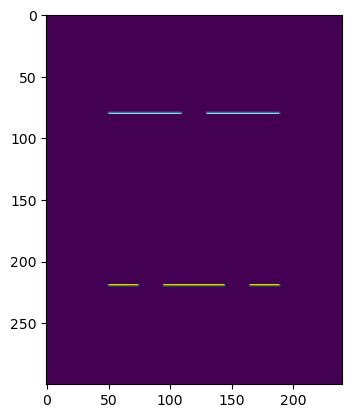

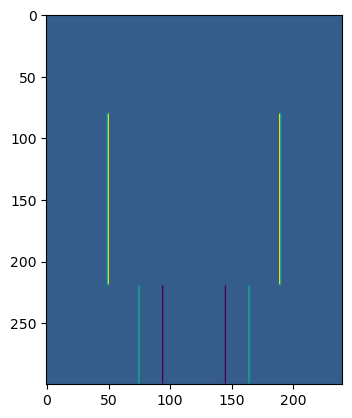

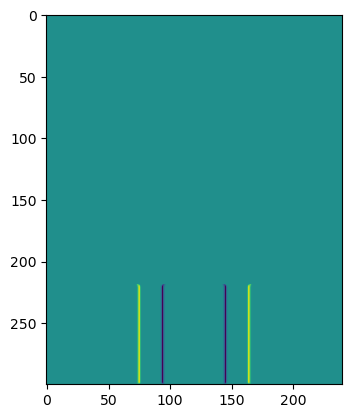

In [16]:
plt.imshow(d_epsilon_dL)
plt.show()
plt.imshow(d_epsilon_dW)
plt.show()
plt.imshow(d_epsilon_dD)
plt.show()

In [17]:
def grads(L, W, D):
    # Constants
    w = 1
    resolution = 20
    fcen = 1
    df = 0.1
    buff = 1
    dpml = 0.5
    sx = 15
    sy = 12
    n = 3

    # Wave number in free space
    k0 = 2 * np.pi / fcen

    # Run the forward simulation
    forward_fields, sim = simulate_mmi(L, W, D, w, resolution, fcen, df, buff, dpml, sx, sy, n)

    #O1_fields=-np.conj(O1_fields)
    # Extract output fields
    O1_fields=extract_O1_fields(sim, forward_fields, L, W, D, w=1, buff=1, dpml=0.5, sx=15, sy=12)

    # Run the adjoint simulation
    adjoint_fields = run_adjoint_simulation_with_symmetry(L, W, D, O1_fields, w=1, resolution=20, fcen=1, df=0.1, buff=1, dpml=0.5, sx=15, sy=12, n=3)
    
    # Compute the permittivity derivatives
    d_epsilon_dL = compute_d_epsilon_dL(L, W, D, w, resolution, buff, dpml, sx, sy, n)
    d_epsilon_dW = compute_d_epsilon_dW(L, W, D, w, resolution, buff, dpml, sx, sy, n)
    d_epsilon_dD = compute_d_epsilon_dD(L, W, D, w, resolution, buff, dpml, sx, sy, n)
    
    
    # Compute the gradient of J with respect to each parameter using integration
    dV = 1 / resolution**2  # Volume element
    grad_L = -2 * (k0**2) * np.real(np.sum(adjoint_fields * d_epsilon_dL * forward_fields) * dV)
    grad_W = -2 * (k0**2) * np.real(np.sum(adjoint_fields * d_epsilon_dW * forward_fields) * dV)
    grad_D = -2 * (k0**2) * np.real(np.sum(adjoint_fields * d_epsilon_dD * forward_fields) * dV)

    return [grad_L, grad_W, grad_D], np.sum(np.abs(O1_fields)**2)

In [18]:
grads(L, W, D)

([-21693.497864007084, -12474.250490289716, -31754.438216779057],
 43.21912594682779)

In [5]:
def compute_derivative(x, y):
    #simple forward_difference
    n = len(x)
    dydx = np.zeros([n])
    dydx[0] = (y[1] - y[0]) / (x[1] - x[0])
    for i in range(1, n - 1):
        dydx[i] = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
    dydx[n-1] = (y[n-1] - y[n-2]) / (x[n-1] - x[n-2])  # Backward diff for the last point
    return dydx

def obj(L, W, D):
    forward_fields, sim = simulate_mmi(L, W, D)
    O1_fields = extract_O1_fields(sim, forward_fields, L, W, D)
    obj_value = np.sum(np.abs(O1_fields)**2)
    return obj_value

In [6]:
Ws=np.linspace(6, 6.1, 21)
Os=[]
Gas=[]
Dfs=[]
for w in Ws:
    print("at wi= "+str(w))
    ga, oa=grads(L, w, D)
    Gas.append(ga[1])
    oa2=obj(L, w+1/20, D)
    Os.append(oa)
    Dfs.append((oa2-oa)*20)

at wi= 6.0


/opt/conda/lib/python3.11/site-packages/meep/source.py:592: RuntimeWarning: EigenModeSource component is not ALL_COMPONENTS (the default), which makes it non-unidirectional.
  warnings.warn(


at wi= 6.005
at wi= 6.01
at wi= 6.015
at wi= 6.02
at wi= 6.025
at wi= 6.03
at wi= 6.035
at wi= 6.04
at wi= 6.045
at wi= 6.05
at wi= 6.055
at wi= 6.06
at wi= 6.0649999999999995
at wi= 6.069999999999999
at wi= 6.074999999999999
at wi= 6.08
at wi= 6.085
at wi= 6.09
at wi= 6.095
at wi= 6.1


In [14]:
Os=np.array(Os)
Gas=np.array(Gas)
Dfs=np.array(Dfs)
dydx=compute_derivative(Os, Ws)

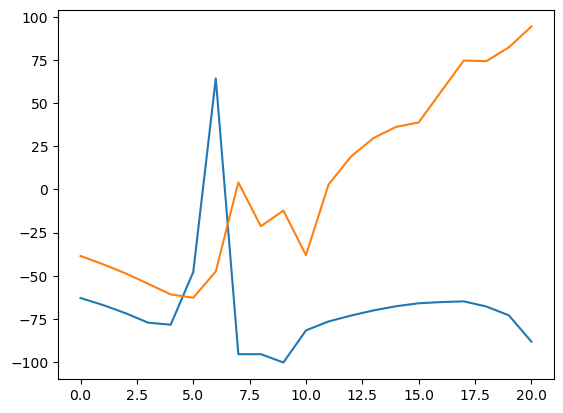

In [15]:
plt.plot(1e-2*Gas)
plt.plot(-Dfs)

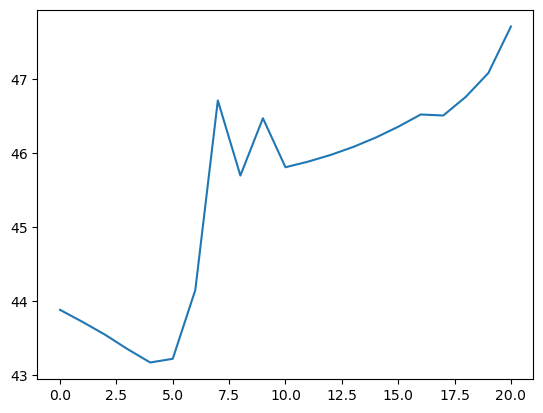

In [12]:
plt.plot(Os)

In [47]:
import numpy as np
from scipy.optimize import minimize

# Constants
fcen = 1
df = 0.1
resolution = 20
buff = 1
dpml = 0.5
sx = 15
sy = 12
n = 3

# Objective function: negative of the integral of O1 fields (since we want to maximize)
def objective(params, *args):
    L, W, D = params
    simulate_mmi, extract_O1_fields = args[:2]
    forward_fields, sim = simulate_mmi(L, W, D)
    O1_fields = extract_O1_fields(sim, forward_fields, L, W, D)
    obj_value = -np.sum(np.abs(O1_fields)**2)
    print(f"Objective Function Value: {-obj_value:.4f} for L={L:.4f}, W={W:.4f}, D={D:.4f}")
    return obj_value

# Gradient function using adjoint method
def gradient(params, *args):
    L, W, D = params
    (
        simulate_mmi,
        extract_O1_fields,
        run_adjoint_simulation_with_symmetry,
        compute_d_epsilon_dL,
        compute_d_epsilon_dW,
        compute_d_epsilon_dD
    ) = args
    forward_fields, sim = simulate_mmi(L, W, D)
    O1_fields = extract_O1_fields(sim, forward_fields, L, W, D)
    adjoint_fields = run_adjoint_simulation_with_symmetry(L, W, D, O1_fields)
    d_epsilon_dL = compute_d_epsilon_dL(L, W, D)
    d_epsilon_dW = compute_d_epsilon_dW(L, W, D)
    d_epsilon_dD = compute_d_epsilon_dD(L, W, D)

    k0 = 2 * np.pi / fcen
    dV = 1 / resolution**2
    grad_L = -2 * (k0**2) * np.real(np.sum(adjoint_fields * d_epsilon_dL * np.conj(forward_fields)) * dV)
    grad_W = -2 * (k0**2) * np.real(np.sum(adjoint_fields * d_epsilon_dW * np.conj(forward_fields)) * dV)
    grad_D = -2 * (k0**2) * np.real(np.sum(adjoint_fields * d_epsilon_dD * np.conj(forward_fields)) * dV)
    
    gradient_vector = np.array([grad_L, grad_W, grad_D])
    print(f"Gradients: dL={grad_L:.4f}, dW={grad_W:.4f}, dD={grad_D:.4f}")
    return gradient_vector

# Initial parameters for L, W, D
initial_params = [5.3, 5.3, 0.52]

# Additional arguments for simulations and gradient calculation
args = (
    simulate_mmi,
    extract_O1_fields,
    run_adjoint_simulation_with_symmetry,
    compute_d_epsilon_dL,
    compute_d_epsilon_dW,
    compute_d_epsilon_dD
)

# Define bounds for parameters L, W, D
bounds = [(5, 7), (5, 7), (0.4, 0.6)]

# Optimization using Scipy's minimize function with bounds
result = minimize(
    objective,
    initial_params,
    args=args,
    method='L-BFGS-B',
    jac=gradient,
    bounds=bounds,  # Include bounds here
    options={'disp': True, 'maxiter': 10}
)

# Print final optimized parameters
print("\nFinal Optimized Parameters:")
print(f"L={result.x[0]:.4f}, W={result.x[1]:.4f}, D={result.x[2]:.4f}")

Objective Function Value: 34.1712 for L=5.3000, W=5.3000, D=0.5200
Gradients: dL=20421.2506, dW=7087.1084, dD=52316.6074
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.41712D+01    |proj g|=  3.00000D-01
Objective Function Value: 46.5957 for L=5.0000, W=5.0000, D=0.4000
Gradients: dL=11328.2600, dW=16160.2571, dD=6669.6723
Objective Function Value: 42.1224 for L=5.2258, W=5.2258, D=0.4903
Gradients: dL=13024.5578, dW=10879.1575, dD=17597.4567

At iterate    1    f= -4.21224D+01    |proj g|=  2.25756D-01
Objective Function Value: 41.0563 for L=5.0019, W=5.0000, D=0.4454
Gradients: dL=11818.5213, dW=12635.4579, dD=10254.1591
Objective Function Value: 35.5633 for L=5.1778, W=5.1774, D=0.4807
Gradients: dL=-5649.1247, dW=293.7887, dD=23080.4941
Objective Function Value: 40.1812 for L=5.2097, W=5.2096, D=0.4871
Gradients: dL=742.0592, dW=8974.2407


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Objective Function Value: 46.5957 for L=5.0000, W=5.0000, D=0.4000
Gradients: dL=11328.2600, dW=16160.2571, dD=6669.6723
Objective Function Value: 35.4045 for L=5.1776, W=5.1776, D=0.4710
Gradients: dL=-16399.0401, dW=-8174.0903, dD=-1980.9887
Objective Function Value: 38.8375 for L=5.2030, W=5.2030, D=0.4812
Gradients: dL=1988.1940, dW=10668.9764, dD=8638.5259
Objective Function Value: 41.3998 for L=5.2199, W=5.2199, D=0.4880
Gradients: dL=8588.7082, dW=10787.9633, dD=19393.5581
Objective Function Value: 41.9198 for L=5.2245, W=5.2245, D=0.4898
Gradients: dL=12051.8542, dW=10969.5251, dD=18280.0985
Objective Function Value: 42.0776 for L=5.2255, W=5.2255, D=0.4902
Gradients: dL=12821.1996, dW=10905.7332, dD=17749.8944
Objective Function Value: 42.1130 for L=5.2257, W=5.2257, D=0.4903
Gradients: dL=12981.9740, dW=10885.0857, dD=17629.7555
Objective Function Value: 42.1205 for L=5.2257, W=5.2257, D=0.4903
Gradients: dL=13015.6281, dW=10880.4168, dD=17604.2457
Objective Function Value: 4

KeyboardInterrupt: 